<center><h1><b>Text Classification with BERTH</b></h1></center>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras as ks
import tensorflow_hub as hub
import tensorflow_text as text

from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity  # to measure the similarity of two vectors

### Data Processing

In [2]:
df = pd.read_csv('/kaggle/input/spam-email/spam.csv')

In [3]:
df[:3]

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...


In [4]:
df.shape

(5572, 2)

In [5]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [6]:
df['Category'].value_counts()

Category
ham     4825
spam     747
Name: count, dtype: int64

### Balancing the Dataset


In [7]:
df_spam = df[df['Category'] == 'spam']
df_spam.shape

(747, 2)

In [8]:
df_ham = df[df['Category'] == 'ham']
df_ham.shape

(4825, 2)

In [9]:
df_ham_downsample = df_ham.sample(df_spam.shape[0], random_state=0)

In [10]:
df_ham_downsample.shape, df_spam.shape

((747, 2), (747, 2))

In [11]:
# Combining df_ham_downsample.shape and df_spam.shape
df_balanced = pd.concat([df_spam, df_ham_downsample])
df_balanced.shape

(1494, 2)

In [12]:
df_balanced['Category'].value_counts()

Category
spam    747
ham     747
Name: count, dtype: int64

In [13]:
df_balanced[:3]

,Category,Message
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
5,spam,FreeMsg Hey there darling it's been 3 week's n...
8,spam,WINNER!! As a valued network customer you have...


In [14]:
# Creating a column for category values that will be converted to binary
df_balanced['spam'] = df_balanced['Category'].apply(lambda x: 1 if x=='spam' else 0)
df_balanced.sample(4)

,Category,Message,spam
5002,ham,"Nope. Since ayo travelled, he has forgotten hi...",0
4256,spam,Block Breaker now comes in deluxe format with ...,1
5501,spam,PRIVATE! Your 2003 Account Statement for 07808...,1
4931,spam,"Hi, the SEXYCHAT girls are waiting for you to ...",1


In [15]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Message'], df_balanced['spam'], stratify=df_balanced['spam'], random_state=0)  # stratify will make distributions of categories equal in the train and test samples

In [16]:
X_train.head(4)

2927                      Im done. Just studyn in library
1021    Good afternoon on this glorious anniversary da...
3421    As a valued customer, I am pleased to advise y...
4058                      Noice. Text me when you're here
Name: Message, dtype: object

# Using Tensorflow on BERTH

In [ ]:
bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")

bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/bert-en-uncased-l-10-h-128-a-2/2")

In [ ]:
# Function to change sentences to vector layer
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']


get_sentence_embeding([
    'Im done. Just studyn in library',
    "Noice. Text me when you're here"
])

In [ ]:
# Trying the encoding on simple words
e = get_sentence_embeding([
    'banana',
    'grapes',
    'mango',
    'jeff bezos',
    'elon musk',
    'bill gates'
])

In [ ]:
e

In [ ]:
# Similairty between two fruits banana and grapes
cosine_similarity([e[0]], [e[1]])

In [ ]:
# Similairty between banana and jeff bezos
cosine_similarity([e[0]], [e[3]])

In [ ]:
# Similairty between bezos and musk
cosine_similarity([e[3]], [e[4]])

## Building Functional Model

In [ ]:
bert_preprocess = hub.KerasLayer("https://kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-preprocess/3")

bert_encoder = hub.KerasLayer("https://www.kaggle.com/models/tensorflow/bert/TensorFlow2/en-uncased-l-12-h-768-a-12/4")

## Please Note: Operations below could not be executed due to unresolvable bug with Tensorflow and Keras

In [ ]:
# BERT Layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural Network Layers
dropout = tf.keras.layers.Dropout(0.1, name='dropout')(outputs['pooled_output'])
output_layer = tf.keras.layers.Dense(1, activation='sigmoid', name='output')(dropout)

# Construct the Final Model
model = tf.keras.Model(inputs=[text_input], outputs=[output_layer])

model.summary()


METRICS = [
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer = 'adam',
              loss = 'binary_crossentropy',
              metrics = METRICS
    
)

model.fit(X_train, y_train, epochs=10)

model.evaluate(X_test, y_test)

y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()


y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_predicted)
cm


from matplotlib import pyplot as plt
import seaborn as sb
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

-----------------

<center><h1><b> Text Classification with Pytorch and Transormers</b></h1></center>

----------------------

In [58]:
import torch
import torch.nn as nn
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import seaborn as sb
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel

In [59]:
# Setting device to use all available GPUs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Clear the cache of unused CUDA memory
torch.cuda.empty_cache()

In [60]:
# Loading the BERT model and tokenizer from Hugging Face's Transformers library
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertModel.from_pretrained('bert-base-uncased')

In [61]:
class BERTBinaryClassifier(nn.Module):
    def __init__(self):
        super(BERTBinaryClassifier, self).__init__()
        # Loading BERT model
        self.bert = bert_model
        # Dropout layer for regularization
        self.dropout = nn.Dropout(0.1)
        # Fully connected layer for binary classification
        self.fc = nn.Linear(768, 1)

    def forward(self, input_ids, attention_mask):
        # BERT encoding (using pooled output for classification)
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        # Applying dropout
        dropout_output = self.dropout(pooled_output)
        # Final output layer with sigmoid for binary classification
        return torch.sigmoid(self.fc(dropout_output))

# Initializing the model and moving to device
model = BERTBinaryClassifier().to(device)

In [62]:
# Use DataParallel to utilize multiple GPUs
if torch.cuda.device_count() > 1:
    model = nn.DataParallel(model)

criterion = nn.BCELoss()  # Binary cross-entropy loss for binary classification
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)

In [63]:
# Function to count model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print('Model Summary:')
print(f'Total trainable parameters: {count_parameters(model)}')

Model Summary:
Total trainable parameters: 109483009


In [64]:
# Defining the function for encoding text data using the tokenizer
def encode_text(text_list):
    # Tokenize and create PyTorch tensors for input_ids and attention_mask
    encoding = tokenizer(text_list, padding=True, truncation=True, max_length=128, return_tensors='pt')
    return encoding['input_ids'].to(device), encoding['attention_mask'].to(device)

In [65]:
# Converting X_train to a list of strings
X_train_text = X_train.tolist() if not isinstance(X_train, list) else X_train

# Ensure y_train has a standard integer index or convert to a NumPy array
y_train = y_train.reset_index(drop=True)  # Option 1: reset index if y_train is a pandas Series

accumulation_steps = 4  # Adjust this value as needed
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for i, text in enumerate(X_train_text):
        inputs, masks = encode_text([text])  # Encoding each text separately to reduce memory
        labels = torch.tensor([y_train[i]]).float().to(device)  # Accessing by standard index
        
        optimizer.zero_grad()
        outputs = model(inputs, masks)

        # Reshape outputs to match labels shape
        loss = criterion(outputs.view(-1), labels)
        loss = loss / accumulation_steps  # Scale loss for accumulation
        loss.backward()
        
        # Update weights after accumulation steps
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(X_train_text):
            optimizer.step()
            running_loss += loss.item()
    
    print(f'Epoch {epoch + 1}/{num_epochs}, Loss: {running_loss}')

# Ensure X_test is a list of strings
X_test_text = X_test.tolist() if not isinstance(X_test, list) else X_test

Epoch 1/10, Loss: 20.67603803705424
Epoch 2/10, Loss: 5.637356561841443
Epoch 3/10, Loss: 1.3667836480308324
Epoch 4/10, Loss: 0.39175252051791176
Epoch 5/10, Loss: 0.21132745643262751
Epoch 6/10, Loss: 0.1365240603336133
Epoch 7/10, Loss: 0.09643773076822981
Epoch 8/10, Loss: 0.07300337610649876
Epoch 9/10, Loss: 0.057307732560730074
Epoch 10/10, Loss: 0.04526551416347502


In [66]:
# Evaluating with additional metrics
model.eval()  # Set the model to evaluation mode
inputs, masks = encode_text(X_test_text)  # Encoding the test text
labels = torch.tensor(y_test.values).float().to(device)  # Converting test labels to tensors
with torch.no_grad():  # No gradient computation for evaluation
    y_pred = model(inputs, masks)  # Getting predictions
    y_pred = y_pred.cpu().numpy()  # Moving predictions to CPU for evaluation
    y_pred = np.where(y_pred > 0.5, 1, 0)

# Computing evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.9706
Precision: 0.9731
Recall: 0.9679


Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.97      0.97       187
           1       0.97      0.97      0.97       187

    accuracy                           0.97       374
   macro avg       0.97      0.97      0.97       374
weighted avg       0.97      0.97      0.97       374



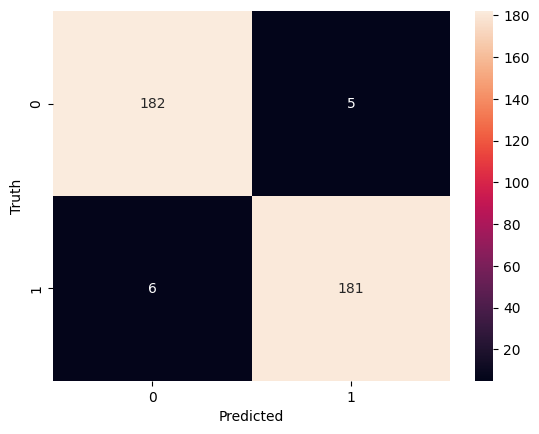

In [67]:
# Step 5: Confusion matrix and classification report
cm = confusion_matrix(y_test, y_pred)  # Compute confusion matrix
print("Classification Report:\n", classification_report(y_test, y_pred))  # Print classification report

# Plot the confusion matrix
sb.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

### Inference

In [68]:
# Inference
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09062223341 from landline. Delivery within 28days. T Cs B0x177, M221BP, 2yr warranty',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005',
    'Hey Sam, are you coming for a cricket game tomorrow?',
    "Why don't you wait till at least Wednesday to see if you get your."
]

In [69]:
# Set the model to evaluation mode
model.eval()

# Encode the review texts and move inputs and masks to the same device
inputs, masks = encode_text(reviews)  # Ensure this function returns tensors

# Disable gradient calculation
with torch.no_grad():
    outputs = model(inputs, masks)  # Get predictions
    logits = outputs  # Since the model's forward method directly returns logits
    y_pred = logits.cpu().numpy()  # Move predictions to CPU for evaluation
    y_pred = np.where(y_pred > 0.5, 1, 0)  # Apply threshold to get binary predictions

# Output the predictions for each review
for review, prediction in zip(reviews, y_pred):
    print(f"Review: '{review}' | Prediction: {'Spam' if prediction == 1 else 'Not Spam'}")

Review: 'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021' | Prediction: Spam
Review: 'You are awarded a SiPix Digital Camera! call 09062223341 from landline. Delivery within 28days. T Cs B0x177, M221BP, 2yr warranty' | Prediction: Spam
Review: 'it to 80488. Your 500 free text messages are valid until 31 December 2005' | Prediction: Spam
Review: 'Hey Sam, are you coming for a cricket game tomorrow?' | Prediction: Not Spam
Review: 'Why don't you wait till at least Wednesday to see if you get your.' | Prediction: Not Spam


_________________________________

### Training With DistilBERT Model

In [31]:
import numpy as np
import pandas as pd
import torch
import transformers as tf
import warnings
warnings.filterwarnings('ignore')

In [32]:
df_balanced[:10]

,Category,Message,spam
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
5,spam,FreeMsg Hey there darling it's been 3 week's n...,1
8,spam,WINNER!! As a valued network customer you have...,1
9,spam,Had your mobile 11 months or more? U R entitle...,1
11,spam,"SIX chances to win CASH! From 100 to 20,000 po...",1
12,spam,URGENT! You have won a 1 week FREE membership ...,1
15,spam,"XXXMobileMovieClub: To use your credit, click ...",1
19,spam,England v Macedonia - dont miss the goals/team...,1
34,spam,Thanks for your subscription to Ringtone UK yo...,1
42,spam,07732584351 - Rodger Burns - MSG = We tried to...,1


In [33]:
# Load the model and tokenizer
ml_cls, tokenizer_cls, pt_weights = (tf.DistilBertModel, tf.DistilBertTokenizer, 'distilbert-base-uncased')
tokenizer = tokenizer_cls.from_pretrained(pt_weights)  
model = ml_cls.from_pretrained(pt_weights)

# Tokenize the messages
tokenized = df_balanced['Message'].apply(lambda x: tokenizer.encode(x, add_special_tokens=True))

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [34]:
print(tokenized[:1])

2    [101, 2489, 4443, 1999, 1016, 1037, 1059, 2243...
Name: Message, dtype: object


In [35]:
max_len = 0
for i in tokenized.values:
    if len(i) > max_len:
        max_len = len(i)

In [36]:
padded = np.array([i + [0] * (max_len - len(i)) for i in tokenized.values])

In [37]:
np.array(padded).shape

(1494, 89)

In [38]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

(1494, 89)

In [39]:
input_ids = torch.tensor(padded)

attention_mask = torch.tensor(attention_mask)

with torch.no_grad():
    last_hidden_states = model(input_ids, attention_mask = attention_mask)

In [40]:
features = last_hidden_states[0][:, 0, :].numpy()

In [41]:
labels = df_balanced['spam']

In [42]:
labels[:2]

2    1
5    1
Name: spam, dtype: int64

In [43]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, stratify=df_balanced['spam'], random_state=0)

In [44]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(train_features, train_labels)

DecisionTreeClassifier()

In [45]:
clf.score(test_features, test_labels)

0.9251336898395722